In [1]:
%matplotlib inline

import numpy as np
from numpy import linalg as nla
import scipy as sp
from scipy import linalg as sla
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import time
import SHFunctions as shf
import os

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
np.set_printoptions(linewidth = 200)

In [2]:
A = shf.MakeGenSingA(3, 2, delta = .00010)
A

array([[[ 0.00000000e+00,  3.17579256e-01,  1.57207443e-02],
        [ 2.25281365e-01,  0.00000000e+00,  1.08018635e-01],
        [ 7.96479828e-02,  2.53652017e-01,  0.00000000e+00]],

       [[-1.00000000e+00,  1.19176025e-01,  2.14123975e-01],
        [ 1.98759943e-01, -1.00000000e+00,  1.34540057e-01],
        [ 1.32945290e-01,  2.00354710e-01, -1.00000000e+00]],

       [[ 1.00000000e-04,  1.99693891e-01,  1.33606109e-01],
        [ 3.31869005e-01,  1.00000000e-04,  1.43099528e-03],
        [ 3.06247030e-01,  2.70529695e-02,  1.00000000e-04]]])

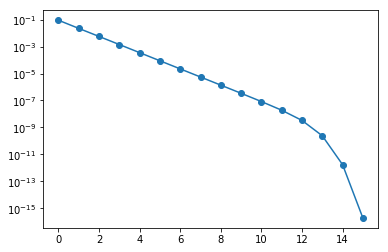

In [3]:
Ss = shf.NewtonPoly(A)
ax = plt.subplot(111)
ax.semilogy(Ss['errs'],'-o')

In [4]:
di = np.zeros((len(Ss['P_Xs']), Ss['P_Xs'][0].shape[0]))
di = di.astype(complex)
i = 0
for P in Ss['P_Xs']:
    d, X = nla.eig(P)
    di[i, :] = d
    i += 1
print(di.dtype)

complex128


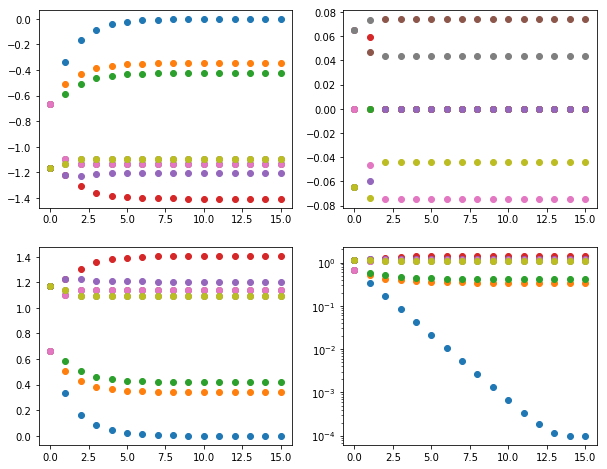

In [5]:
fig, axes = plt.subplots(2, 2,figsize=(10, 8))
for i in range(di.shape[1]):
    axes[0,0].plot(np.real(di[:,i]),'o')
    axes[0,1].plot(np.imag(di[:,i]),'o')
    axes[1,0].plot(np.absolute(di[:,i]),'o')
    axes[1,1].semilogy(np.absolute(di[:,i]),'o')
    i += 1

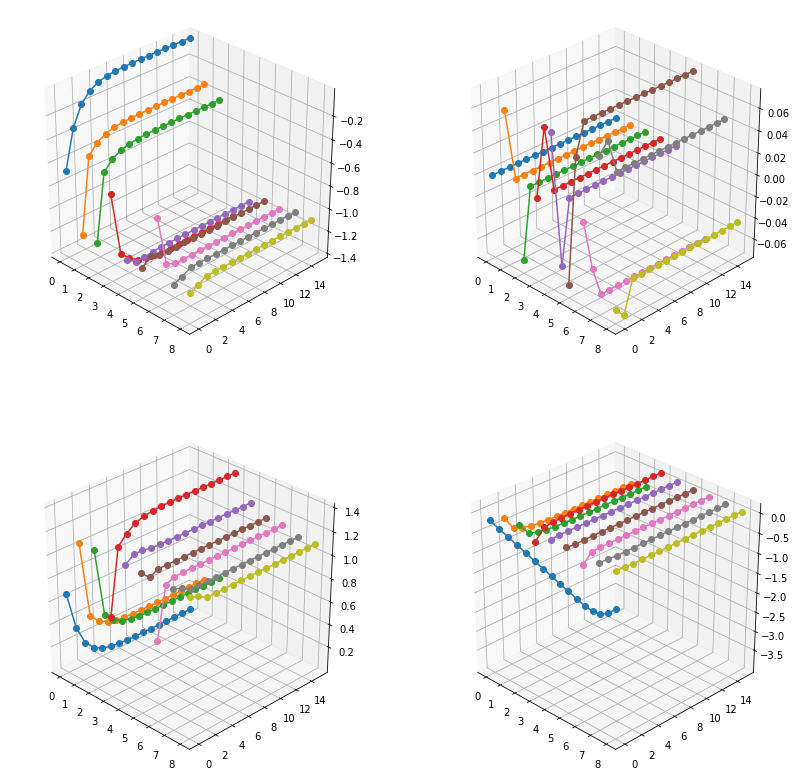

In [6]:
fig1 = plt.figure(figsize=(14,14))
ax1 = fig1.add_subplot(221, projection='3d')
ax2 = fig1.add_subplot(222, projection='3d')
ax3 = fig1.add_subplot(223, projection='3d')
ax4 = fig1.add_subplot(224, projection='3d')
for i in range(di.shape[1]):
    ax1.plot(i*np.ones(di.shape[0]), np.arange(di.shape[0]), np.real(di[:,i]),'-o')
    ax2.plot(i*np.ones(di.shape[0]), np.arange(di.shape[0]), np.imag(di[:,i]),'-o')
    ax3.plot(i*np.ones(di.shape[0]), np.arange(di.shape[0]), np.absolute(di[:,i]),'-o')
    ax4.plot(i*np.ones(di.shape[0]), np.arange(di.shape[0]), np.log10(np.absolute(di[:,i])),'-o')
    i += 1
ax1.view_init(30, 315)
ax2.view_init(30, 315)
ax3.view_init(30, 315)
ax4.view_init(30, 315)

In [7]:
Ss['Hs'][-1]

array([[-5.67495891e-09, -7.91420847e-09, -2.55293543e-09],
       [-5.67495886e-09, -7.91420839e-09, -2.55293542e-09],
       [-5.67495891e-09, -7.91420834e-09, -2.55293542e-09]])